# NeuroMANCER Node and System classes and modules tutorial

This script demonstrates how to use NeuroMANCER Node to wrap arbitrary callable
into symbolic representation that can be used in NeuroMANCER problem formulation.


### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install git+https://github.com/pnnl/neuromancer.git@master

### Import

In [1]:
import torch
from neuromancer.system import Node, System

## Node

**Node** is a simple class to create symbolic modules out of arbitrary PyTorch callables.
Node class is wrapping the callable and defines the computational node based 
on input_keys and output_keys that define computational node connections through 
intermediate dictionaries. Complex symbolic architectures can be constructed by connecting
input and output keys of a set of Nodes via System and Problem classes.
   

In [2]:
# 1, wrap nn.Linear into Node
net_1 = torch.nn.Linear(1, 1)
node_1 = Node(net_1, ['x1'], ['y1'])
# print input and output keys
print(node_1.input_keys)
print(node_1.output_keys)
# evaluate forward pass of the node with dictionary input dataset
print(node_1({'x1': torch.rand(1)}))

['x1']
['y1']
{'y1': tensor([0.3839], grad_fn=<AddBackward0>)}


In [3]:
# 2, wrap nn.Sequential into Node
net_2 = torch.nn.Sequential(torch.nn.Linear(2, 5),
                            torch.nn.ReLU(),
                            torch.nn.Linear(5, 3),
                            torch.nn.ReLU(),
                            torch.nn.Linear(3, 1))
node_2 = Node(net_2, ['x2'], ['y2'])
# evaluate forward pass of the node with dictionary input dataset
print(node_2({'x2': torch.rand(2)}))

{'y2': tensor([0.3309], grad_fn=<AddBackward0>)}


In [4]:
# 3, wrap arbitrary callable into Node - allows for unwrapping the inputs
fun_1 = lambda x1, x2: 2.*x1 - x2**2
node_3 = Node(fun_1, ['y1', 'y2'], ['y3'], name='quadratic')
# evaluate forward pass of the node with dictionary input dataset
print(node_3({'y1': torch.rand(2), 'y2': torch.rand(2)}))

{'y3': tensor([-0.4780, -0.1845])}


In [5]:
# 4, wrap callable with multiple inputs and outputs
def fun_2(x1, x2):
    return x1**2, x2**2
node_4 = Node(fun_2, ['x1', 'x2'], ['x1^2', 'x2^2'], name='square')
# evaluate forward pass of the node with dictionary input dataset
print(node_4({'x1': torch.rand(2), 'x2': torch.rand(2)}))

{'x1^2': tensor([0.0238, 0.3855]), 'x2^2': tensor([0.1190, 0.0036])}


## Modules

NeuroMANCER also provides implementation of useful building blocks for
creating custom neural architectures. These include:
* modules.blocks          - neural architecures
* modules.activations     - custom activation functions    
* modules.functions       - useful callables 
* modules.gnn             - graph neural nets
* modules.rnn             - recurent neural nets
* modules.solvers         - iterative solvers for constrained optimization
* slim.linear             - linear algebra factorizations for weights
        
Next set of example shows how to wrap NeuroMANCER modules into Node

In [6]:
from neuromancer.modules import blocks
from neuromancer.modules import activations
from neuromancer import slim

In [7]:
# for a full list of available blocks (nn.Modules) in NeuroMANCER see:
print(blocks.blocks)
# for a full list of available activations in NeuroMANCER see:
print(activations.activations)

{'mlp': <class 'neuromancer.modules.blocks.MLP'>, 'rnn': <class 'neuromancer.modules.blocks.RNN'>, 'pytorch_rnn': <class 'neuromancer.modules.blocks.PytorchRNN'>, 'linear': <class 'neuromancer.modules.blocks.Linear'>, 'residual_mlp': <class 'neuromancer.modules.blocks.ResMLP'>, 'basislinear': <class 'neuromancer.modules.blocks.BasisLinear'>, 'bilinear': <class 'neuromancer.modules.blocks.BilinearTorch'>, 'icnn': <class 'neuromancer.modules.blocks.InputConvexNN'>, 'pos_def': <class 'neuromancer.modules.blocks.PosDef'>}
{'softexp': <class 'neuromancer.modules.activations.SoftExponential'>, 'blu': <class 'neuromancer.modules.activations.BLU'>, 'aplu': <class 'neuromancer.modules.activations.APLU'>, 'prelu': <class 'neuromancer.modules.activations.PReLU'>, 'pelu': <class 'neuromancer.modules.activations.PELU'>, 'relu': <class 'torch.nn.modules.activation.ReLU'>, 'gelu': <class 'torch.nn.modules.activation.GELU'>, 'rrelu': <class 'torch.nn.modules.activation.RReLU'>, 'hardtanh': <class 'tor

In [8]:
# 1, instantiate 4-layer multilayer perceptron with linear weight and ReLU activation
block_1 = blocks.MLP(insize=2, outsize=3,
                  bias=True,
                  linear_map=slim.maps['linear'],
                  nonlin=torch.nn.ReLU,
                  hsizes=[80] * 4)
# wrap modules into Node
node_4 = Node(block_1, ['x3'], ['y3'])
# evaluate forward pass of the node with dictionary input dataset
data = {'x3': torch.rand(10, 2)}
print(node_4(data).keys())
print(node_4(data)['y3'].shape)

dict_keys(['y3'])
torch.Size([10, 3])


In [9]:
# 2, instantiate recurrent neural net without bias, SVD linear map, and BLI activation
block_2 = blocks.RNN(insize=2, outsize=2,
                  bias=False,
                  linear_map=slim.linear.SVDLinear,
                  nonlin=activations.BLU,
                  hsizes=[80] * 4)
# wrap modules into Node
node_5 = Node(block_2, ['x4'], ['y4'])
# evaluate forward pass of the node with dictionary input dataset
data = {'x4': torch.rand(10, 2)}
print(node_5(data).keys())
print(node_5(data)['y4'].shape)

dict_keys(['y4'])
torch.Size([10, 2])


## System

**System** is a class that supports construction of cyclic computational graphs in NeuroMANCER.
System's graph is defined by a list of Nodes. Instantiated System can be used to simulate
dynamical systems in open or closed loop rollouts by specifying number of steps via nsteps.

In [10]:
# 1, create acyclic symbolic graph
# list of nodes to construct the graph
nodes = [node_1, node_2, node_3]
# 10 steps rollout
nsteps = 3
# connecting nodes via System class
system_1 = System(nodes, nsteps=nsteps)
# print input and output keys
print(system_1.input_keys)
print(system_1.output_keys)
# evaluate forward pass of the System with 3D input dataset
batch = 2
print(system_1({'x1': torch.rand(batch, nsteps, 1),
                'x2': torch.rand(batch, nsteps, 2)}))

['x2', 'x1']
['y3', 'y2', 'y1']
{'x1': tensor([[[0.4631],
         [0.9713],
         [0.9532]],

        [[0.2440],
         [0.8362],
         [0.1995]]]), 'x2': tensor([[[0.0867, 0.7658],
         [0.1031, 0.6752],
         [0.3701, 0.2770]],

        [[0.8793, 0.1238],
         [0.7189, 0.5221],
         [0.6867, 0.1354]]]), 'y1': tensor([[[ 0.0706],
         [ 0.4807],
         [ 0.4661]],

        [[-0.1062],
         [ 0.3717],
         [-0.1421]]], grad_fn=<CatBackward0>), 'y2': tensor([[[0.3319],
         [0.3319],
         [0.3320]],

        [[0.3319],
         [0.3318],
         [0.3320]]], grad_fn=<CatBackward0>), 'y3': tensor([[[ 0.0311],
         [ 0.8512],
         [ 0.8219]],

        [[-0.3226],
         [ 0.6332],
         [-0.3944]]], grad_fn=<CatBackward0>)}


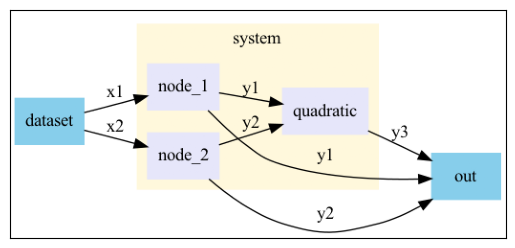

In [11]:
# visualize symbolic computational graph
system_1.show()

In [12]:
# 2, close the loop by creating recursion in one of the nodes
nodes[2].output_keys = ['y1']
# create new system with cyclic computational graph
system_2 = System(nodes, nsteps=nsteps)
# print input and output keys
print(system_2.input_keys)
print(system_2.output_keys)
# evaluate forward pass of the System with 3D input dataset
print(system_1({'x1': torch.rand(batch, nsteps, 1),
                'x2': torch.rand(batch, nsteps, 2)}))

['x1', 'x2', 'y1']
['y2', 'y1']
{'x1': tensor([[[0.9485],
         [0.5909],
         [0.8132]],

        [[0.2703],
         [0.8262],
         [0.4282]]]), 'x2': tensor([[[0.2526, 0.5902],
         [0.0565, 0.8939],
         [0.3888, 0.3947]],

        [[0.8917, 0.5474],
         [0.4589, 0.1174],
         [0.9786, 0.3943]]]), 'y1': tensor([[[ 0.4623],
         [ 0.8145],
         [ 0.1737],
         [ 1.5188],
         [ 0.3531],
         [ 0.2372]],

        [[-0.0850],
         [-0.2797],
         [ 0.3636],
         [-0.6697],
         [ 0.0424],
         [ 0.6173]]], grad_fn=<CatBackward0>), 'y2': tensor([[[0.3319],
         [0.3318],
         [0.3320]],

        [[0.3313],
         [0.3321],
         [0.3314]]], grad_fn=<CatBackward0>)}


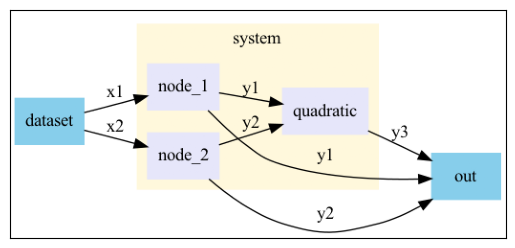

In [13]:
# visualize symbolic computational graph
system_1.show()